In [1]:
import string
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, r2_score
from sklearn.model_selection import (train_test_split, learning_curve, cross_val_score, cross_val_predict, 
ShuffleSplit, KFold)
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder


nlp = spacy.load('en_core_web_sm')
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "!", "#", "$", "%", "&", "(", ")", "*", "+", "-",
                                                     ".", "/", ":", ";",
                                                     "<", "=", ">", "?", "@", "[", "]", "^", "_", "`", "{", "|", "}",
                                                     "~", "'"]
ignore_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
                'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
                'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
                'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
                'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
                'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
                'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
                'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
                'all', 'any', 'both', 'each', 'other', 'some', 'such', 'no', 'nor',
                'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
                'should', 'now', 'uses', 'use', 'using', 'used', 'one', 'also']

dataset = pd.read_csv(r'SampleDataset.csv', sep=",", engine='python')
dataset.drop(['date', 'title'], axis=1, inplace=True)
print("Old shape:", dataset.shape)


# Data cleaning function
def clean_data(dataset):
    # Remove punctuations
    dataset['text'] = dataset['text'].str.replace(',', " ")
    dataset['text'] = dataset['text'].str.replace('“', " ")
    dataset['text'] = dataset['text'].str.replace("\'", " ")
    dataset['text'] = dataset['text'].str.replace('’', " ")
    # Make sure any double-spaces are single
    dataset['text'] = dataset['text'].str.replace('  ', ' ')
    dataset['text'] = dataset['text'].str.replace("\n", " ").replace("\r", " ")
    dataset['text'] = dataset['text'].str.replace("  ", " ")
    # Drop duplicate rows
    dataset.drop_duplicates(subset=['text'], inplace=True)
    print("New shape:", dataset.shape)
    return dataset


data = clean_data(dataset)
dataframe = data
rows_list = []
lemmas = []
global tokens


def Remove_StopWords(docs):
    global tokens
    lemmas = []
    for tok in docs:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
        tokens = lemmas
        tokens = [tok for tok in tokens if tok not in STOPLIST]
        tokens = [w.lower() for w in tokens if w not in ignore_words]
        tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens


def generate_ngrams(s, n):
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]


for output in dataframe.text:
    doc = nlp(output)
    vocabulary = Remove_StopWords(doc)
    vectorizer = CountVectorizer(tokenizer=vocabulary, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
    diction = [x.lemma_ for x in [y for y in nlp(str(vectorizer.tokenizer)) if not y.is_stop and y.pos_ != 'PUNCT']]
    bigram = generate_ngrams(diction, 2)
    rows_list.append(bigram)

df = pd.DataFrame(rows_list)
df['News'] = df[df.columns[0:]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df["Type"] = dataframe["Type"]
dfModel = pd.DataFrame(df[{"News", "Type"}])
dfModel = dfModel.dropna()

X = dfModel.News.values
y = dfModel.Type.values

Old shape: (1000, 4)
New shape: (997, 4)


Logistic Regression Classifier 

Training Accuracy  0.99568345323741
Training Validated scores: Mean: 0.97 (+/- Std: 0.03)

R2 Score: 0.8922231233666756

Predicted Accuracy score 97.32%
Misclassified samples: 8

execution time is 2.1713647842407227


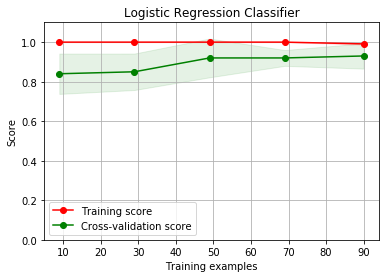

In [2]:
from sklearn.datasets import make_classification
le = LabelEncoder()
y = le.fit_transform(y)

start = time.time()
tf_idf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
X_tf_idf = tf_idf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.3)

logit = LogisticRegression(solver='liblinear')
# train model
logit.fit(X_train, y_train)

scores = cross_val_score(logit, X_train, y_train, cv=10)

print("Logistic Regression Classifier \n")
print("Training Accuracy ",logit.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = logit.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()
print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()   

end = time.time()
print("execution time is",end - start)


def plot_learing_curve(pipe, title):
    size = 10
    cv = KFold(size, shuffle=False)
    X = dfModel['News']
    y = dfModel['Type']

    X_tf_idf = tf_idf.fit_transform(X)
    pipe = pipe.fit(X_tf_idf, y)

    X, y = make_classification(n_classes=2, n_clusters_per_class=2, shuffle=True)
    train_sizes, train_scores, test_scores = learning_curve(pipe, X, y, n_jobs=5, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()

    # box-like grid
    plt.grid()

    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")

    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(0, 1.1)
    plt.legend(loc="best")
    plt.show()

plot_learing_curve(logit, "Logistic Regression Classifier")

SVM Classifier 

Training Accuracy  1.0
Training Validated scores: Mean: 0.87 (+/- Std: 0.06)

R2 Score: 0.44928122192273134

Predicted Accuracy score 86.29%
Misclassified samples: 41

execution time is 16.870262622833252


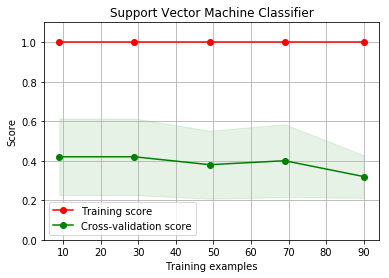

In [3]:
from sklearn.datasets import make_classification
le = LabelEncoder()

start = time.time()

tf_idf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
X = dfModel.News.values
X_tf_idf = tf_idf.fit_transform(X)
y=dfModel.Type.values

#  Train the classifier
svm = svm.SVC(kernel='rbf', random_state=0, gamma=3, C=1.0)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.3)

# get predictions for article section
svm.fit(X_train, y_train)

scores = cross_val_score(svm, X_train, y_train, cv=10)

print("SVM Classifier \n")
print("Training Accuracy ",svm.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = svm.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

def plot_learing_curve(pipe, title):
    size = 10
    cv = KFold(size, shuffle=False)
    X = dfModel['News']
    y = dfModel['Type']

    x_vectors = tf_idf.fit_transform(X)
    pipe = pipe.fit(x_vectors, y)

    X, y = make_classification(n_classes=2, n_clusters_per_class=2, shuffle=True)
    train_sizes, train_scores, test_scores = learning_curve(pipe, X, y, n_jobs=5, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()

    # box-like grid
    plt.grid()

    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")

    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(0, 1.1)
    plt.legend(loc="best")
    plt.show()

plot_learing_curve(svm, "Support Vector Machine Classifier")

Logistic Regression Classifier 

Training Accuracy  0.9985652797704447
Training Validated scores: Mean: 0.97 (+/- Std: 0.07)

R2 Score: 0.8932574275040028

Predicted Accuracy score 97.33%
Misclassified samples: 8

execution time is 2.8326570987701416


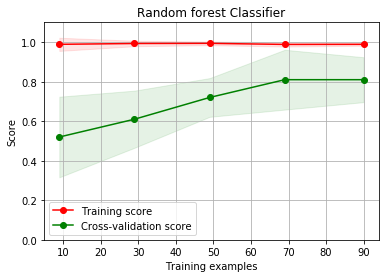

In [4]:
from sklearn.datasets import make_classification
le = LabelEncoder()
y = le.fit_transform(y)

start = time.time()

vectorizer = CountVectorizer(analyzer = 'word',stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
x_vectors = vectorizer.fit_transform(dataset.text.values)
y = dataset.Type.values

X_train, X_test, y_train, y_test = train_test_split(x_vectors, y, test_size=0.3, random_state=42) # Get a training and test dataset

# n_estimators is the number of random forests to use
# n_jobs says to use all processors available
rf = RandomForestClassifier(n_estimators=10, criterion = 'entropy')
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_train, y_train, cv=10)
print("Logistic Regression Classifier \n")
print("Training Accuracy ",rf.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = rf.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()  

end = time.time()
print("execution time is",end - start)

def plot_learing_curve(pipe, title):
    size = 10
    cv = KFold(size, shuffle=False)
    X = dataset['text']
    y = dataset['Type']

    x_vectors = vectorizer.fit_transform(X)
    pipe.fit(x_vectors, y)

    X, y = make_classification(n_classes=2, n_clusters_per_class=2, shuffle=True)
    train_sizes, train_scores, test_scores = learning_curve(pipe, X, y, n_jobs=5, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()

    # box-like grid
    plt.grid()

    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")

    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(0, 1.1)
    plt.legend(loc="best")
    plt.show()

plot_learing_curve(rf, "Random forest Classifier")